# Data-driven portfolio management

In [166]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
from functools import reduce
import re
import matplotlib.pyplot as plt

In [167]:
df1 = pd.read_csv('data/amundi-msci-wrld-ae-c.csv')
df2 = pd.read_csv('data/ishares-global-corporate-bond-$.csv')
df3 = pd.read_csv('data/db-x-trackers-ii-global-sovereign-5.csv')
df4 = pd.read_csv('data/spdr-gold-trust.csv')
df5 = pd.read_csv('data/usdollar.csv')

In [168]:
df1

,Date,Price,Open,High,Low,Change %
0,"Dec 31, 2020",204.58,204.58,204.58,204.58,0.62%
1,"Dec 30, 2020",203.32,203.32,203.32,203.32,-0.33%
2,"Dec 29, 2020",204.00,204.00,204.00,204.00,-0.01%
3,"Dec 28, 2020",204.02,204.02,204.02,204.02,0.41%
4,"Dec 24, 2020",203.19,203.19,203.19,203.19,0.32%
...,...,...,...,...,...,...
242,"Jan 08, 2020",195.26,195.26,195.26,195.26,0.49%
243,"Jan 07, 2020",194.30,194.30,194.30,194.30,0.25%
244,"Jan 06, 2020",193.81,193.81,193.81,193.81,-0.16%
245,"Jan 03, 2020",194.12,194.12,194.12,194.12,-0.24%


In [169]:
def toDate(df):
    df['Date'] =  pd.to_datetime(df['Date'],format='%b %d, %Y')

In [170]:
toDate(df1)
toDate(df2)
toDate(df3)
toDate(df4)
toDate(df5)


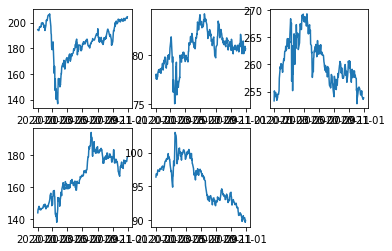

In [171]:
x = df1.Date
y = df1.Price

plt.subplot(2, 3, 1)
plt.plot(x,y)

x = df2.Date
y = df2.Price

plt.subplot(2, 3, 2)
plt.plot(x,y)

x = df3.Date
y = df3.Price

plt.subplot(2, 3, 3)
plt.plot(x,y)

x = df4.Date
y = df4.Price

plt.subplot(2, 3, 4)
plt.plot(x,y)

x = df5.Date
y = df5.Price

plt.subplot(2, 3, 5)
plt.plot(x,y)


plt.show()



In [172]:
df1

,Date,Price,Open,High,Low,Change %
0,2020-12-31,204.58,204.58,204.58,204.58,0.62%
1,2020-12-30,203.32,203.32,203.32,203.32,-0.33%
2,2020-12-29,204.00,204.00,204.00,204.00,-0.01%
3,2020-12-28,204.02,204.02,204.02,204.02,0.41%
4,2020-12-24,203.19,203.19,203.19,203.19,0.32%
...,...,...,...,...,...,...
242,2020-01-08,195.26,195.26,195.26,195.26,0.49%
243,2020-01-07,194.30,194.30,194.30,194.30,0.25%
244,2020-01-06,193.81,193.81,193.81,193.81,-0.16%
245,2020-01-03,194.12,194.12,194.12,194.12,-0.24%


In [173]:
df_list = [df1, df2, df3, df4, df5]
df_final = reduce(lambda left,right: pd.merge(left,right,on='Date', how='outer'), df_list)
df_final.drop(['Open_x', 'High_x', 'Low_x', 'Change %_x','Open_y', 'High_y', 'Low_y', 'Vol._x', 'Change %_y','Open_x', 'High_x', 'Low_x', 'Vol._y', 'Change %_x','Open_y', 'High_y', 'Low_y', 'Vol._x', 'Change %_y','Open','High', 'Low', 'Vol._y', 'Change %'],axis=1,inplace=True)
df_final.columns = ['Date','ST','CB','PB','GO','CA']
df_final

,Date,ST,CB,PB,GO,CA
0,2020-12-31,204.58,80.62,NaN,178.36,89.94
1,2020-12-30,203.32,80.42,253.84,177.70,89.68
2,2020-12-29,204.00,80.86,253.82,176.35,89.99
3,2020-12-28,204.02,NaN,253.55,175.71,90.34
4,2020-12-24,203.19,80.11,NaN,176.35,90.32
...,...,...,...,...,...,...
279,2020-05-02,NaN,NaN,NaN,159.78,NaN
280,2020-04-13,NaN,NaN,NaN,161.41,99.35
281,2020-12-25,NaN,NaN,NaN,NaN,90.32
282,2020-04-10,NaN,NaN,NaN,NaN,99.52


In [174]:
df_main=df_final.fillna(method='ffill',axis=0)
#index with Date
#df_main = df_main.set_index('Date', drop=False).drop('20200101') #########¿Should we remove first row?

df_main=df_main.sort_values('Date',ascending=True,ignore_index=True)



In [175]:
df_main=df_main.mask(df_main=='Nan', None).ffill()

In [176]:
df_main.isnull().values.any()

False

### 3.1 Portfolio allocation

Portfolio allocation: automatic generation of portfolio allocations must be generated, where the ∆ or increment/decrement in each asset weight is 0.05 (5%). Note that the sum of asset weights for a portfolio mix must be always equal to 1.0 (100%). Table 3.6 shows the schema for portfolio generation.

In [10]:
asset_type=['Stock','CorpBond','PublicBond','Gold','Cash']


df = pd.DataFrame(columns=asset_type)


input_rows=[]
for a in range(21):
    for b in range(21-a):
        for c in range(21-a-b):
            for d in range(21-a-b-c):
                e=20-a-b-c-d
                #print([a*0.05,b*0.05,c*0.05,d*0.05,e*0.05])
                input_rows.append([a*0.05,b*0.05,c*0.05,d*0.05,e*0.05])
                


row_list = []

for row in input_rows:
    dict1 = dict(Stock=row[0], CorpBond=row[1],PublicBond=row[2], Gold=row[3],Cash=row[4])
    row_list.append(dict1)
df_allocations = pd.DataFrame(row_list)
df_allocations

#df.to_csv("portfolio_allocations.csv")


,Stock,CorpBond,PublicBond,Gold,Cash
0,0.00,0.00,0.00,0.00,1.00
1,0.00,0.00,0.00,0.05,0.95
2,0.00,0.00,0.00,0.10,0.90
3,0.00,0.00,0.00,0.15,0.85
4,0.00,0.00,0.00,0.20,0.80
...,...,...,...,...,...
10621,0.95,0.00,0.00,0.00,0.05
10622,0.95,0.00,0.00,0.05,0.00
10623,0.95,0.00,0.05,0.00,0.00
10624,0.95,0.05,0.00,0.00,0.00


### 3.2 Trading methodology

for the different portfolio allocations generated previously, apply
the trading methodologies, shown in Table 3.5, with and without rebalancing.
As part of this subtask, trading methodologies generated should be stored in the file trading_methodologies.csv in order to be used in later tasks and also to allow indi- vidual validation of this subtask.


In [311]:
df_main.head()

,Date,ST,CB,PB,GO,CA
0,2020-01-01,194.59,79.43,259.95,161.41,96.39
1,2020-01-02,194.59,77.58,253.28,143.95,96.85
2,2020-01-03,194.12,78.03,255.12,145.86,96.84
3,2020-01-06,193.81,77.50,254.16,147.39,96.67
4,2020-01-07,194.30,77.73,254.36,147.97,97.00


In [46]:
df_main.tail()

,Date,ST,CB,PB,GO,CA
279,2020-12-25,194.59,79.43,259.95,161.41,90.32
280,2020-12-28,204.02,80.86,253.55,175.71,90.34
281,2020-12-29,204.00,80.86,253.82,176.35,89.99
282,2020-12-30,203.32,80.42,253.84,177.70,89.68
283,2020-12-31,204.58,80.62,253.84,178.36,89.94


All the funds are invested the first day. The money invested is split among the assets according to the portfolio allocation defined.
Example 3.2 One off investment
Let’s suppose an investor has 100$ to invest using the following portfolio allocation: 50 / 20 / 0 / 20 / 10. For the one off investment, the 100$ are completely invested the first day according to weights. The following table shows how is computed the amount of shares bought, assuming an hypothetical price:


#### 1-off buy

In [76]:
import numpy as np
#one_off_buy
money_in=100
date_in="2020-12-25"
#amount should be equal to money_in*allocation
amount=np.array([50, 20, 20, 0, 10])

filtered_df = df_main.loc[df_main['Date'] == date_in]
filtered_df=filtered_df.to_numpy()

price=np.array([filtered_df[0,1],filtered_df[0,2],filtered_df[0,3],filtered_df[0,4],1])
shares=amount/price
print (shares)



[ 0.25695051  0.25179403  0.07693787  0.         10.        ]


The funds are equally divided in as many amounts as months available in the investment period. Later, each monthly amount is invested the first day of each month, splitting such monthly amount among the assets according to the portfolio mix defined.


#### DCA buy

In [309]:
money_in=100
date_in="2020-01-01"
date_out="2020-06-15"

#Date in datetime format
m=re.compile(r'\d+')
date_in=m.findall(date_in)
date_in=np.array(date_in).astype(int)

m=re.compile(r'\d+')
date_out=m.findall(date_out)
date_out=np.array(date_out).astype(int)

date_in= datetime.date(date_in[0],date_in[1],date_in[2])
date_out=datetime.date(date_out[0],date_out[1],date_out[2])
#------------------------------------------------------------------------------------------------#
n_months = ((date_out.year - date_in.year) * 12 + (date_out.month - date_in.month))
if(date_in.day>date_out.day):
    n_months-=1
    
#first day next month
date_in = (date_in.replace(day=1) + datetime.timedelta(days=32)).replace(day=1)

#cycle and store the price of the different periods in a df
delta = datetime.timedelta(days=1)
frames=[]
for i in range(n_months):
    filtered_df = df_main.loc[df_main['Date'] == str(date_in)]
    while (filtered_df.index.size < 1):
        filtered_df = df_main.loc[df_main['Date'] == str(date_in)]
        date_in+=delta
    
    frames.append(filtered_df)
    date_in = (date_in.replace(day=1) + datetime.timedelta(days=32)).replace(day=1)


a=pd.concat(frames)
print(a)
a=a.iloc[:,1:]
print(a)

#now work with weigh

          Date      ST     CB      PB      GO     CA
23  2020-02-03  194.59  79.43  259.95  148.36  97.80
43  2020-03-02  182.42  81.36  262.95  149.20  97.36
65  2020-04-01  149.96  76.82  267.37  149.45  99.67
87  2020-05-01  194.59  79.38  266.35  159.78  99.08
112 2020-06-01  194.59  81.22  263.52  163.66  97.83
         ST     CB      PB      GO     CA
23   194.59  79.43  259.95  148.36  97.80
43   182.42  81.36  262.95  149.20  97.36
65   149.96  76.82  267.37  149.45  99.67
87   194.59  79.38  266.35  159.78  99.08
112  194.59  81.22  263.52  163.66  97.83


# Till Here

## Till here

### Till here

In [79]:
#2. Dollar Cost Averaging (DCA)

def DCA(money_in, date_out):

	#---------------------------------------------------------------
	#ST
	#---------------------------------------------------------------	


    #Obtain first day of month
    m1_list = list()
    d1_list = list()
    
    for date in df_main['Date']:
        if re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(2) not in m1_list:
            if re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(3) == '01':
                m1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(2))
                d1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(0))
            elif re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(3) == '02':
                m1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(2))
                d1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(0))
            elif re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(3) == '03':
                m1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(2))
                d1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(0))
            elif re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(3) == '04':
                m1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(2))
                d1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(0))
    print(d1_list, len(d1_list))
    print(m1_list, len(m1_list))

    #Price the first day of the month
    #12 lists (months) with 5 elements (assets)
    price_in = list()
    for date_in in d1_list:
        price_in_i = list()
        price_in.append(price_in_i) #append list for each month
        for header in df_main:
            if header =='Date':
                continue
            if header == 'CA':
                price_in_i.append(1)
            else:
                price_in_i.append(df_main.loc[date_in, header])
                
	#print("price in", price_in, len(price_in))

    #INPUT
    n_month_ST = len(m1_list)
    money_month = money_in/n_month_ST #money per month to buy
    asset = [50, 20, 20, 0, 10]
    asset_month = [i / n_month_ST for i in asset] #list with 5 elements

    #12 lists equals with 5 elements (€)
    amount_in = list()
    for month in d1_list:
        amount_in_i = list()
        amount_in.append(amount_in_i)
        for i in asset_month:
            amount_in_i.append((i/100) * money_month)
        
    '''
    print('Asset', asset)
    print('Asset month', asset_month)
    print('Money month', money_month)
    print('Amount in ', amount_in, len(amount_in))
    '''


    #Shares bought for each month. List of assets for each month 
    #12 lists with 5 assets each one	
    shares_dca = list()
    for price_month, amount_month in zip(price_in, amount_in):
        shares_dca_i = list()
        for price_asset, amount_asset in zip(price_month, amount_month):
            shares_dca_i.append(amount_asset / price_asset)
        shares_dca.append(shares_dca_i)
	#print("Shares", shares_dca, len(shares_dca))


	#OUTPUT 

    #Obtain price to sell
    #1 list of 5 elements (assets) for a date
    price_sell = list()
    for i in df_main:
        if i =='Date':
            pass
        elif i == 'CA':
            price_sell.append(1)
        else:
            price_sell.append(df_main.loc[date_out, i])


	#Obtain final amount, 12 lists with 5 elements
	#NOTE: for each month the buy price its different to the sell price
	#so the final amount if date_buy = date_sell only is the same in the first month
    amount_fin = list()
    for share_month in shares_dca:
        n = 0
        amount_fin_i = list()
        for share_asset, price in zip(share_month, price_sell):

            if share_asset == 0:
                amount_fin_i.append(0)
                n = n+1
            else:
                amount_fin_i.append((share_asset * price) / (asset_month[n]/100) * (asset_month[n]/100))
                n = n+1
        amount_fin.append(amount_fin_i)

    print("INITIAL 0", amount_in[0], len(amount_in))
    print("FINAL 0", amount_fin[0], len(amount_fin))
    print("INITIAL 1", amount_in[1], len(amount_in))
    print("FINAL 1", amount_fin[1], len(amount_fin))
    #REBALANCE
        

    return shares_dca



money = 100
date_in = '20200102'
date_out = '20200102'
#one_off(money, date_in, date_out)

DCA(money, date_out)

#reb(date_out)

TypeError: expected string or bytes-like object

In [90]:
#TRADING METHODOLOGY
#1. One off (1-OFF)  


def one_off(money_in, date_in, date_out):
    asset = [50, 20, 20, 0, 10]
    '''
    ST_1off = list()
    PB_1off = list()
    CB_1off = list()
    GO_1off = list()
    CA_1off = list()
    '''
    #Price of the asset to buy. List len 5
    price_in = list()
    for i in df_main:
        if i =='Date':
            pass
        elif i == 'CA':
            price_in.append(1)
        else:
            price_in.append(df_main.loc[date_in, i])

    print(price_in)	

    #Initial amount in each asset
    amount_in = list()
    print(asset[1], type(asset[1]))
    for i in asset:
        amount_in.append((i/100) * money_in)

    #Shares bought
    shares_1off = list()
    for price, amount in zip(price_in, amount_in):
        shares_1off.append(amount / price)

    print(shares_1off)

    #OUTPUT 

    #Obtain price to sell
    price_sell = list()
    for i in df_main:
        if i =='Date':
            pass
        elif i == 'CA':
            price_sell.append(1)
        else:
            price_sell.append(df_main.loc[date_out, i])

    #Money obtain after sell in each asset
    amount_fin = list()
    n = 0
    for share, price in zip(shares_1off, price_sell):
        if asset[n] == 0:
            amount_fin.append(0)
            n = n+1
        else:
            amount_fin.append ((share * price) / (asset[n]/100) * (asset[n]/100))
            n = n+1


    #REBALANCE
    rebalance_dif = list() #Difference in % in portfolio allocation
    for ini, fin in zip(amount_in, amount_fin): 
        rebalance_dif.append(ini/sum(amount_in) - fin/sum(amount_fin))

    amount_reb = list()
    for percentage, amount_fin in zip(rebalance_dif, amount_fin):
        if percentage > 0:
            amount_reb.append()

    return shares_1off







money = 100
date_in = '2020-01-02'
date_out = '2020-01-02'
one_off(money, date_in, date_out)


#reb(date_out)
	

[Date
2020-01-02    194.59
Name: ST, dtype: float64, Date
2020-01-02    77.58
Name: CB, dtype: float64, Date
2020-01-02    253.28
Name: PB, dtype: float64, Date
2020-01-02    143.95
Name: GO, dtype: float64, 1]
20 <class 'int'>
[Date
2020-01-02    0.256951
Name: ST, dtype: float64, Date
2020-01-02    0.257798
Name: CB, dtype: float64, Date
2020-01-02    0.078964
Name: PB, dtype: float64, Date
2020-01-02    0.0
Name: GO, dtype: float64, 10.0]


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 28 17:20:51 2021

@author: zhuo
"""
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
from functools import reduce
import re
'''
df1 = pd.read_csv('amundi-msci-wrld-ae-c.csv')
df2 = pd.read_csv('ishares-global-corporate-bond-$.csv')
df3 = pd.read_csv('db-x-trackers-ii-global-sovereign-5.csv')
df4 = pd.read_csv('spdr-gold-trust.csv')
df5 = pd.read_csv('usdollar.csv')
'''
#concat and discard irrelevant columns and rename
df_list = [df1, df2, df3, df4, df5]
df_final = reduce(lambda left,right: pd.merge(left,right,on='Date', how='outer'), df_list)
df_final.drop(['Open_x', 'High_x', 'Low_x', 'Change %_x','Open_y', 'High_y', 'Low_y', 'Vol._x', 'Change %_y','Open_x', 'High_x', 'Low_x', 'Vol._y', 'Change %_x','Open_y', 'High_y', 'Low_y', 'Vol._x', 'Change %_y','Open','High', 'Low', 'Vol._y', 'Change %'],axis=1,inplace=True)
df_final.columns = ['Date','ST','CB','PB','GO','CA']

#convert date to sortable values and sort
date=df_final['Date'].str[8:12]+df_final['Date'].str[0:3].replace("Dec","12").replace("Nov","11").replace("Oct","10").replace("Sep","09").replace("Aug","08").replace("Jul","07").replace("Jun","06").replace("May","05").replace("Apr","04").replace("Mar","03").replace("Feb","02").replace("Jan","01")+df_final['Date'].str[4:6]
df_final['Date'] = date.values
df_final.sort_values(by='Date',inplace=True)


#fill in NaN by the previous trading day
df_main=df_final.fillna(method='ffill',axis=0)
#index with Date
df_main = df_main.set_index('Date', drop=False).drop('20200101') #########¿Should we remove first row?

print(df_main)
df_main.to_csv("prices.csv")



#INVESTMENT PORTFOLIO


#TRADING METHODOLOGY
#1. One off (1-OFF)  


def one_off(money_in, date_in, date_out):
	asset = [50, 20, 20, 0, 10]
	'''
	ST_1off = list()
	PB_1off = list()
	CB_1off = list()
	GO_1off = list()
	CA_1off = list()
	'''
	#Price of the asset to buy. List len 5
	price_in = list()
	for i in df_main:
		if i =='Date':
			pass
		elif i == 'CA':
			price_in.append(1)
		else:
			price_in.append(df_main.loc[date_in, i])

	print(price_in)	

	#Initial amount in each asset
	amount_in = list()
	print(asset[1], type(asset[1]))
	for i in asset:
		amount_in.append((i/100) * money_in)

	#Shares bought
	shares_1off = list()
	for price, amount in zip(price_in, amount_in):
		shares_1off.append(amount / price)

	print(shares_1off)	

	#OUTPUT 

	#Obtain price to sell
	price_sell = list()
	for i in df_main:
		if i =='Date':
			pass
		elif i == 'CA':
			price_sell.append(1)
		else:
			price_sell.append(df_main.loc[date_out, i])

	#Money obtain after sell in each asset
	amount_fin = list()
	n = 0
	for share, price in zip(shares_1off, price_sell):
		if asset[n] == 0:
			amount_fin.append(0)
			n = n+1
		else:
			amount_fin.append ((share * price) / (asset[n]/100) * (asset[n]/100))
			n = n+1


	#REBALANCE
	rebalance_dif = list() #Difference in % in portfolio allocation
	for ini, fin in zip(amount_in, amount_fin): 
		rebalance_dif.append(ini/sum(amount_in) - fin/sum(amount_fin))

	amount_reb = list()
	for percentage, amount_fin in zip(rebalance_dif, amount_fin):
		if percentage > 0:
			amount_reb.append()




	return shares_1off



#2. Dollar Cost Averaging (DCA)

def DCA(money_in, date_out):

	#---------------------------------------------------------------
	#ST
	#---------------------------------------------------------------	


	#Obtain first day of month
	m1_list = list()
	d1_list = list()
	
	for date in df_main['Date']:
		if re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(2) not in m1_list:
			if re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(3) == '01':
				m1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(2))
				d1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(0))
			elif re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(3) == '02':
				m1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(2))
				d1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(0))
			elif re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(3) == '03':
				m1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(2))
				d1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(0))
			elif re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(3) == '04':
				m1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(2))
				d1_list.append(re.search(r"(\d{1,4})(\d{1,2})(\d{1,2})", date).group(0))
	print(d1_list, len(d1_list))
	print(m1_list, len(m1_list))

	#Price the first day of the month
	#12 lists (months) with 5 elements (assets)
	price_in = list()
	for date_in in d1_list:
		price_in_i = list()
		price_in.append(price_in_i) #append list for each month
		for header in df_main:
			if header =='Date':
				continue
			if header == 'CA':
				price_in_i.append(1)
			else:
				price_in_i.append(df_main.loc[date_in, header])
			
	#print("price in", price_in, len(price_in))

	#INPUT
	n_month_ST = len(m1_list)
	money_month = money_in/n_month_ST #money per month to buy
	asset = [50, 20, 20, 0, 10]
	asset_month = [i / n_month_ST for i in asset] #list with 5 elements

	#12 lists equals with 5 elements (€)
	amount_in = list()
	for month in d1_list:
		amount_in_i = list()
		amount_in.append(amount_in_i)
		for i in asset_month:
			amount_in_i.append((i/100) * money_month)
	
	'''
	print('Asset', asset)
	print('Asset month', asset_month)
	print('Money month', money_month)
	print('Amount in ', amount_in, len(amount_in))
	'''


	#Shares bought for each month. List of assets for each month 
	#12 lists with 5 assets each one	
	shares_dca = list()
	for price_month, amount_month in zip(price_in, amount_in):
		shares_dca_i = list()
		for price_asset, amount_asset in zip(price_month, amount_month):
			shares_dca_i.append(amount_asset / price_asset)
		shares_dca.append(shares_dca_i)
	#print("Shares", shares_dca, len(shares_dca))
d

	#OUTPUT 

	#Obtain price to sell
	#1 list of 5 elements (assets) for a date
	price_sell = list()
	for i in df_main:
		if i =='Date':
			pass
		elif i == 'CA':
			price_sell.append(1)
		else:
			price_sell.append(df_main.loc[date_out, i])


	#Obtain final amount, 12 lists with 5 elements
	#NOTE: for each month the buy price its different to the sell price
	#so the final amount if date_buy = date_sell only is the same in the first month
	amount_fin = list()
	for share_month in shares_dca:
		n = 0
		amount_fin_i = list()
		for share_asset, price in zip(share_month, price_sell):

			if share_asset == 0:
				amount_fin_i.append(0)
				n = n+1
			else:
				amount_fin_i.append((share_asset * price) / (asset_month[n]/100) * (asset_month[n]/100))
				n = n+1
		amount_fin.append(amount_fin_i)

	print("INITIAL 0", amount_in[0], len(amount_in))
	print("FINAL 0", amount_fin[0], len(amount_fin))
	print("INITIAL 1", amount_in[1], len(amount_in))
	print("FINAL 1", amount_fin[1], len(amount_fin))

	#REBALANCE
	

	return shares_dca




money = 100
date_in = '20200102'
date_out = '20200102'
#one_off(money, date_in, date_out)

DCA(money, date_out)

#reb(date_out)
	
